--- Performance and Efficiency Benchmarking ---
Running efficient thinning-based simulation...
Thinning simulation finished in 0.0100 seconds.

Running direct baseline simulation (this may be slow)...
Direct simulation finished in 0.9823 seconds.

Speedup: The thinning algorithm was 98.32 times faster than the direct simulation.

--- Correctness and Fidelity Validation ---
Kolmogorov-Smirnov Test Results:
  - K-S Statistic: 0.0912
  - p-value: 0.7561
  - Conclusion: At 5.0% significance level, we cannot reject the null hypothesis.
    The distribution of potential inter-arrival times is consistent with the theoretical exponential distribution.
    This provides confidence in the simulation's statistical correctness.

--- Visualization of Accepted Events ---


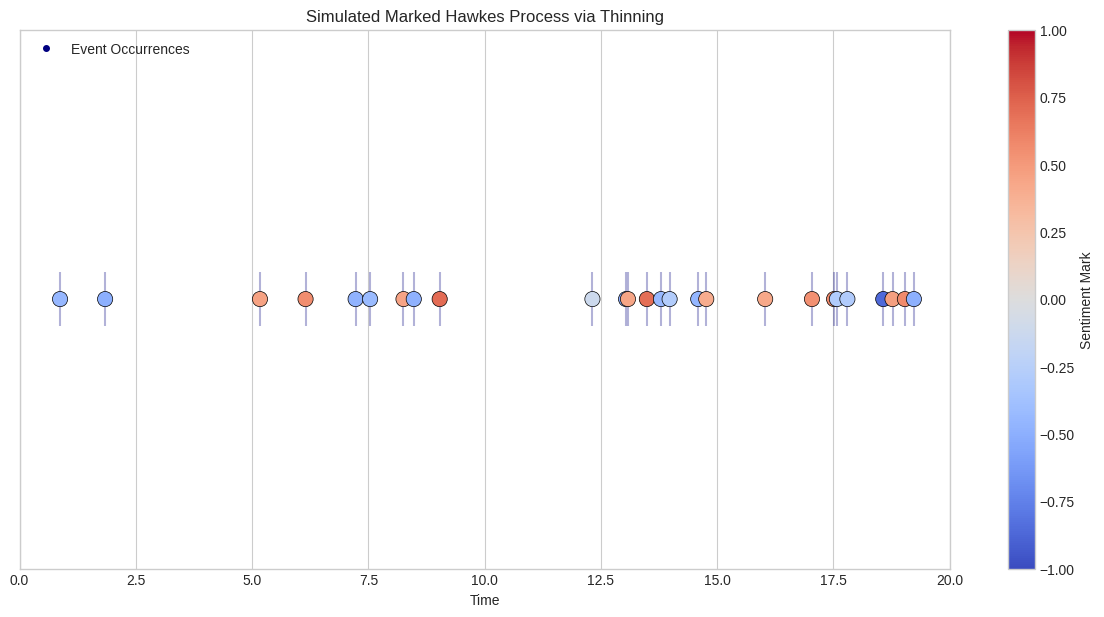

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.stats import kstest, expon

# --- User-Defined Model Components with Dummy Data (Unchanged) ---

def calculate_true_intensity(t, history, base_intensity=0.1, alpha=0.8, beta=1.0):
    """
    Calculates the true, computationally expensive intensity lambda(t).
    This function now simulates an intensity derived from both self-excitation
    and a proxy for the density of a covariance matrix of option greeks.
    """
    # 1. Standard Hawkes self-excitation component
    excitation = 0
    for event_time in history:
        excitation += alpha * np.exp(-beta * (t - event_time))

    # 2. Dummy calculation for covariance matrix density of option greeks
    # This part is a placeholder for a more complex, real-world calculation.
    # We use a random matrix to simulate the effect on intensity.
    num_options = 5
    greeks_matrix = np.random.rand(num_options, num_options)
    covariance_matrix = greeks_matrix.T @ greeks_matrix
    # The determinant acts as a proxy for the 'density' or 'volume' of the covariance matrix.
    # A small regularization term is added for numerical stability.
    volatility_component = 0.05 * np.linalg.det(covariance_matrix + np.eye(num_options) * 1e-6)

    return base_intensity + excitation + volatility_component

def calculate_majorizing_intensity(t, history, last_update_time, last_majorizing_intensity):
    """
    Calculates a simpler, piecewise-constant majorizing intensity lambda_bar(t).
    This function must always be >= calculate_true_intensity(t, history).
    It is updated only when a new event is accepted.
    """
    if not history:
        # Before any events, use a default starting intensity.
        return (0.5, 0.0, 0.5)

    last_event_time = history[-1]
    # The majorizing intensity is a step function, recalculated only after a new event.
    if last_event_time > last_update_time:
        # Add a small buffer to ensure the majorizing function is always greater.
        new_majorizing_intensity = calculate_true_intensity(last_event_time, history) + 0.2
        return (new_majorizing_intensity, last_event_time, new_majorizing_intensity)
    else:
        # If no new event, the majorizing intensity remains constant.
        return (last_majorizing_intensity, last_update_time, last_majorizing_intensity)

def get_mark():
    """
    Generates a mark for an accepted event by sampling from a dummy
    bimodal distribution representing sentiment score density.
    This simulates drawing a sentiment score from a complex distribution.
    """
    # 60% chance of being from the positive sentiment cluster
    if np.random.rand() < 0.6:
        return np.random.normal(loc=0.5, scale=0.1)
    # 40% chance of being from the negative sentiment cluster
    else:
        return np.random.normal(loc=-0.4, scale=0.15)

# --- Simulation Algorithms ---

def simulate_marked_hawkes_thinning(T_max, max_events=1000):
    """
    Simulates a marked Hawkes process using the efficient generate-and-thin algorithm.
    Returns accepted events, potential inter-arrival times, and average majorizing rate.
    """
    t = 0.0
    history = []
    marked_events = []

    potential_inter_arrival_times = []
    majorizing_intensities = []

    last_update_time = -1.0
    last_majorizing_intensity = 0.0

    while t < T_max and len(marked_events) < max_events:
        # Get the current value of the majorizing (upper-bound) intensity
        lambda_bar, update_time, intensity_val = calculate_majorizing_intensity(t, history, last_update_time, last_majorizing_intensity)
        last_update_time = update_time
        last_majorizing_intensity = intensity_val
        majorizing_intensities.append(lambda_bar)

        if lambda_bar <= 0: break # Stop if intensity drops to zero

        # Generate a potential event time by sampling from the majorizing process
        dt = np.random.exponential(1.0 / lambda_bar)
        potential_inter_arrival_times.append(dt)
        t += dt

        if t >= T_max: break # Stop if we exceed the simulation time horizon

        # Calculate the true intensity at the potential event time
        lambda_true = calculate_true_intensity(t, history)
        # In rare cases, ensure lambda_bar is still dominant
        if lambda_true > lambda_bar: lambda_bar = lambda_true

        # Accept or "thin" the potential event with probability lambda_true / lambda_bar
        acceptance_prob = lambda_true / lambda_bar

        if np.random.uniform(0, 1) < acceptance_prob:
            # If accepted, record the event and its mark
            history.append(t)
            mark = get_mark()
            marked_events.append((t, mark))

    avg_lambda_bar = np.mean(majorizing_intensities) if majorizing_intensities else 0
    return marked_events, potential_inter_arrival_times, avg_lambda_bar

def simulate_marked_hawkes_direct(T_max, dt=0.001):
    """
    Simulates the same process using a direct, non-thinned baseline method.
    This is expected to be much slower as it checks for an event at every small time step.
    """
    t = 0.0
    history = []
    marked_events = []

    while t < T_max:
        lambda_t = calculate_true_intensity(t, history)

        # Probability of an event in the small interval dt is approximately lambda(t) * dt
        prob_event = lambda_t * dt

        # Bernoulli trial to see if an event occurs in this interval
        if np.random.uniform(0, 1) < prob_event:
            history.append(t)
            mark = get_mark()
            marked_events.append((t, mark))

        t += dt

    return marked_events

# --- Benchmarking and Validation Functions ---

def run_kolmogorov_smirnov_test(inter_arrival_times, avg_lambda_bar):
    """
    Performs a Kolmogorov-Smirnov test to validate the simulation's correctness.
    It checks if the potential events are generated from the correct exponential distribution.
    This is a key goodness-of-fit test for the thinning algorithm.
    """
    print("\n--- Correctness and Fidelity Validation ---")
    if not inter_arrival_times or avg_lambda_bar == 0:
        print("Not enough data to perform K-S test.")
        return

    # The scale parameter for the exponential distribution is 1 / rate (lambda)
    scale = 1.0 / avg_lambda_bar

    # Perform the K-S test against a theoretical exponential distribution
    ks_statistic, p_value = kstest(inter_arrival_times, 'expon', args=(0, scale))

    print(f"Kolmogorov-Smirnov Test Results:")
    print(f"  - K-S Statistic: {ks_statistic:.4f}")
    print(f"  - p-value: {p_value:.4f}")

    alpha = 0.05
    if p_value > alpha:
        print(f"  - Conclusion: At {alpha*100}% significance level, we cannot reject the null hypothesis.")
        print("    The distribution of potential inter-arrival times is consistent with the theoretical exponential distribution.")
        print("    This provides confidence in the simulation's statistical correctness.")
    else:
        print(f"  - Conclusion: At {alpha*100}% significance level, we reject the null hypothesis.")
        print("    The distribution of potential inter-arrival times does NOT match the theoretical exponential distribution.")
        print("    This may indicate an issue with the simulation logic or the majorizing function.")

# --- Main Execution and Analysis ---

if __name__ == "__main__":
    simulation_time = 20.0  # Reduced time for faster baseline execution

    # 1. Run and time the efficient thinning simulation
    print("--- Performance and Efficiency Benchmarking ---")
    print("Running efficient thinning-based simulation...")
    start_time_thinning = time.time()
    events, potential_times, avg_rate = simulate_marked_hawkes_thinning(T_max=simulation_time)
    end_time_thinning = time.time()
    duration_thinning = end_time_thinning - start_time_thinning
    print(f"Thinning simulation finished in {duration_thinning:.4f} seconds.")

    # 2. Run and time the direct baseline simulation
    print("\nRunning direct baseline simulation (this may be slow)...")
    start_time_direct = time.time()
    direct_events = simulate_marked_hawkes_direct(T_max=simulation_time)
    end_time_direct = time.time()
    duration_direct = end_time_direct - start_time_direct
    print(f"Direct simulation finished in {duration_direct:.4f} seconds.")

    # 3. Calculate and report speedup
    if duration_thinning > 0 and duration_direct > 0:
        speedup = duration_direct / duration_thinning
        print(f"\nSpeedup: The thinning algorithm was {speedup:.2f} times faster than the direct simulation.")

    # 4. Run correctness validation on the thinning algorithm's output
    run_kolmogorov_smirnov_test(potential_times, avg_rate)

    # 5. Visualize the final output from the thinning simulation
    print("\n--- Visualization of Accepted Events ---")
    if events:
        # Correctly unpack the list of (time, mark) tuples
        event_times = [e[0] for e in events]
        event_marks = [e[1] for e in events]

        plt.style.use('seaborn-v0_8-whitegrid')
        fig, ax = plt.subplots(figsize=(15, 7))
        # Plot event occurrences as simple stems
        ax.plot(event_times, np.zeros_like(event_times), 'o', color='navy', label='Event Occurrences', markersize=4)
        ax.vlines(event_times, ymin=-0.1, ymax=0.1, color='navy', alpha=0.3)
        # Use a scatter plot to show the marks, colored by value
        sc = ax.scatter(event_times, np.zeros_like(event_times), c=event_marks, cmap='coolwarm', s=120, vmin=-1, vmax=1, zorder=5, edgecolors='black', linewidth=0.5)
        cbar = plt.colorbar(sc)
        cbar.set_label('Sentiment Mark')
        ax.set_yticks([]) # Hide y-axis ticks for clarity
        ax.set_xlabel('Time')
        ax.set_title('Simulated Marked Hawkes Process via Thinning')
        ax.set_xlim(0, simulation_time)
        ax.set_ylim(-1, 1) # Set limits to contain the color bar legend
        ax.legend(loc='upper left')
        plt.show()
    else:
        print("No events were generated in the simulation.")

